In [57]:
import pandas as pd

# Load the dataset
df = pd.read_csv('C:/Users/User/fraudTrain.csv')

# Display the first few rows of the dataset
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,01/01/2019 00:00,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",09/03/1988,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,01/01/2019 00:00,6.304230e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,21/06/1978,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,01/01/2019 00:00,3.885950e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,19/01/1962,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,01/01/2019 00:01,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,12/01/1967,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,01/01/2019 00:03,3.755340e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,28/03/1986,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
from sklearn.utils import resample

In [6]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from scipy.sparse import csr_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from scipy.sparse import csr_matrix
from sklearn.utils import resample
df = pd.read_csv('C:/Users/User/fraudTrain.csv')


In [7]:
# Correct the format and parse dates
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M', dayfirst=True)
df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y', dayfirst=True)


In [8]:
# Extract relevant features from timestamps
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day
df['trans_month'] = df['trans_date_trans_time'].dt.month
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year

In [9]:
# Drop original timestamp and Dob
df = df.drop(columns=['trans_date_trans_time', 'dob'])


In [10]:

# Separate majority and minority classes
df_majority = df[df.is_fraud == 0]
df_minority = df[df.is_fraud == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=6006,   # to match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_balanced['is_fraud'].value_counts())


is_fraud
0    6006
1    6006
Name: count, dtype: int64


In [11]:
# Define categorical and numerical features
categorical_features = ['category', 'gender', 'job', 'state', 'city']
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'trans_hour', 'trans_day', 'trans_month', 'age']


In [12]:
# Create preprocessing pipelines for both numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [13]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [14]:
# Separate features and target
X = df_balanced.drop(columns=['is_fraud'])
y = df_balanced['is_fraud']

In [15]:
# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)

In [16]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


In [17]:
# Reshape for CNN
X_train_reshaped = X_train.toarray().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.toarray().reshape((X_test.shape[0], X_test.shape[1], 1))

In [18]:

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))



In [19]:


# Define CNN model
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1437, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 718, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 22976)             0         
                                                                 
 dense (Dense)               (None, 100)               2297700   
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,297,929
Trainable params: 2,297,929
Non-trainable params: 0
______________________________________________

In [20]:


# Train the CNN model with class weights
cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_data=(X_test_reshaped, y_test), class_weight=class_weights_dict)


Epoch 1/10
151/151 [==============================] - 12s 72ms/step - loss: 0.4914 - accuracy: 0.7536 - val_loss: 0.3846 - val_accuracy: 0.8231
Epoch 2/10
151/151 [==============================] - 9s 59ms/step - loss: 0.3314 - accuracy: 0.8600 - val_loss: 0.3235 - val_accuracy: 0.8539
Epoch 3/10
151/151 [==============================] - 10s 66ms/step - loss: 0.2771 - accuracy: 0.8813 - val_loss: 0.2762 - val_accuracy: 0.8860
Epoch 4/10
151/151 [==============================] - 10s 66ms/step - loss: 0.2464 - accuracy: 0.8978 - val_loss: 0.2765 - val_accuracy: 0.8810
Epoch 5/10
151/151 [==============================] - 9s 61ms/step - loss: 0.2210 - accuracy: 0.9089 - val_loss: 0.2380 - val_accuracy: 0.9030
Epoch 6/10
151/151 [==============================] - 10s 68ms/step - loss: 0.1927 - accuracy: 0.9245 - val_loss: 0.2369 - val_accuracy: 0.9010
Epoch 7/10
151/151 [==============================] - 9s 61ms/step - loss: 0.1652 - accuracy: 0.9337 - val_loss: 0.2376 - val_accuracy: 0.

Epoch 1/10
151/151 [==============================] - 9s 57ms/step - loss: 0.4866 - accuracy: 0.7666 - val_loss: 0.3754 - val_accuracy: 0.8281
Epoch 2/10
151/151 [==============================] - 7s 49ms/step - loss: 0.3313 - accuracy: 0.8560 - val_loss: 0.3043 - val_accuracy: 0.8752
Epoch 3/10
151/151 [==============================] - 8s 55ms/step - loss: 0.2840 - accuracy: 0.8790 - val_loss: 0.2893 - val_accuracy: 0.8722
Epoch 4/10
151/151 [==============================] - 7s 49ms/step - loss: 0.2538 - accuracy: 0.8943 - val_loss: 0.2693 - val_accuracy: 0.8876
Epoch 5/10
151/151 [==============================] - 8s 53ms/step - loss: 0.2312 - accuracy: 0.9016 - val_loss: 0.2592 - val_accuracy: 0.8897
Epoch 6/10
151/151 [==============================] - 8s 50ms/step - loss: 0.2137 - accuracy: 0.9111 - val_loss: 0.2506 - val_accuracy: 0.8939
Epoch 7/10
151/151 [==============================] - 8s 55ms/step - loss: 0.1957 - accuracy: 0.9216 - val_loss: 0.2645 - val_accuracy: 0.8872

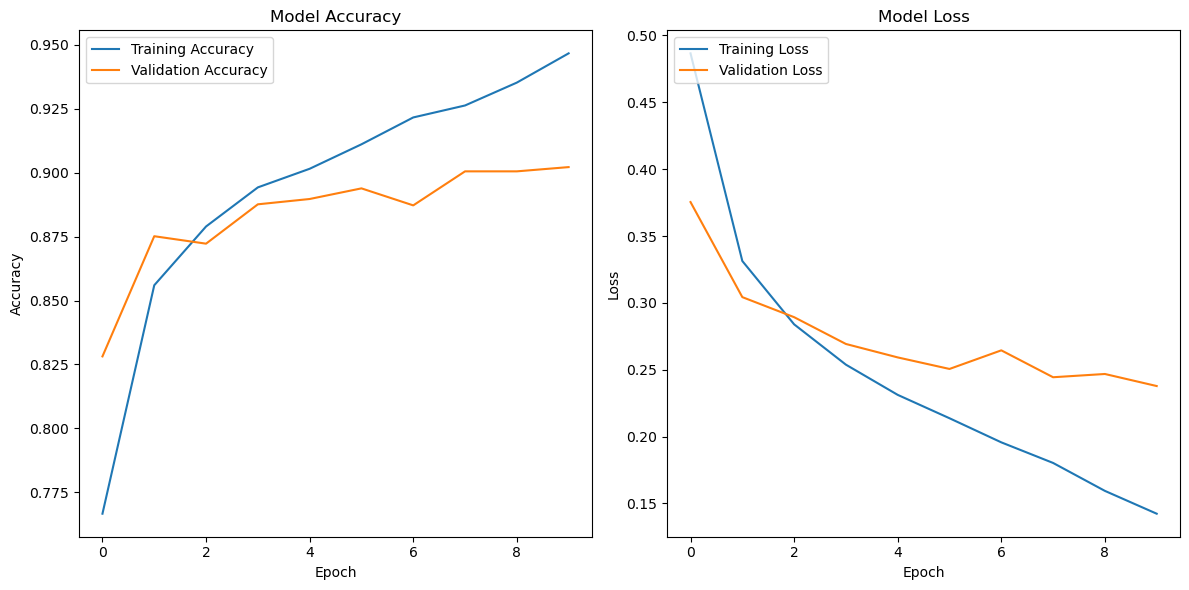

In [22]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define and compile the CNN model (assuming you are using the same CNN model)
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_data=(X_test_reshaped, y_test))

# Make predictions
cnn_predictions = cnn_model.predict(X_test_reshaped)
cnn_predictions = (cnn_predictions > 0.5).astype(int)

# Evaluation metrics
def evaluate_model(predictions, y_test):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return accuracy, precision, recall, f1

cnn_metrics = evaluate_model(cnn_predictions, y_test)
print("CNN Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*cnn_metrics))

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/10
151/151 [==============================] - 144s 923ms/step - loss: 0.6933 - accuracy: 0.4964 - val_loss: 0.6930 - val_accuracy: 0.5077
Epoch 2/10
151/151 [==============================] - 140s 930ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6930 - val_accuracy: 0.4940
Epoch 3/10
151/151 [==============================] - 141s 933ms/step - loss: 0.6930 - accuracy: 0.4951 - val_loss: 0.6928 - val_accuracy: 0.4940
Epoch 4/10
151/151 [==============================] - 140s 926ms/step - loss: 0.6929 - accuracy: 0.4964 - val_loss: 0.6927 - val_accuracy: 0.4940
Epoch 5/10
151/151 [==============================] - 138s 916ms/step - loss: 0.6925 - accuracy: 0.5038 - val_loss: 0.6928 - val_accuracy: 0.4940
Epoch 6/10
151/151 [==============================] - 138s 917ms/step - loss: 0.6921 - accuracy: 0.5031 - val_loss: 0.6926 - val_accuracy: 0.4940
Epoch 7/10
151/151 [==============================] - 140s 926ms/step - loss: 0.6921 - accuracy: 0.4960 - val_loss: 0.6925 -

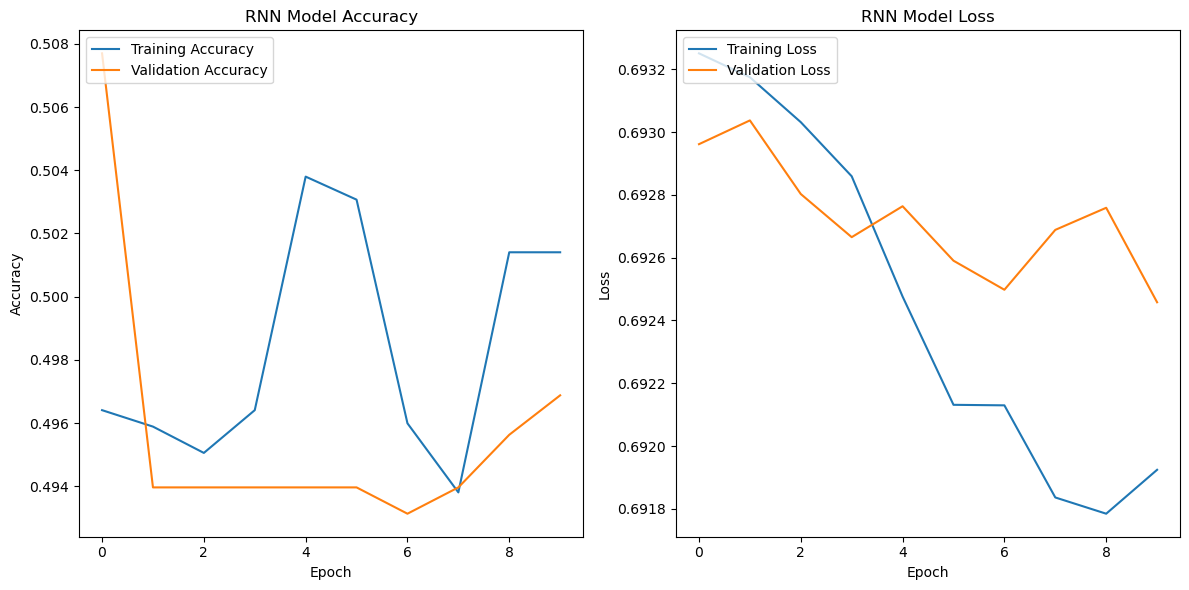

In [23]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define and compile the RNN model
rnn_model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], 1)),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
rnn_history = rnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_data=(X_test_reshaped, y_test))

# Make predictions
rnn_predictions = rnn_model.predict(X_test_reshaped)
rnn_predictions = (rnn_predictions > 0.5).astype(int)

# Evaluation metrics
rnn_metrics = evaluate_model(rnn_predictions, y_test)
print("RNN Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*rnn_metrics))

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [35]:
import numpy as np
from keras.utils import Sequence

class SparseMatrixBatchGenerator(Sequence):
    def __init__(self, X_sparse, y, batch_size):
        self.X_sparse = X_sparse
        self.y = y
        self.batch_size = batch_size
        self.indexes = np.arange(X_sparse.shape[0])  # Use shape[0] to determine the number of samples

    def __len__(self):
        return int(np.ceil(self.X_sparse.shape[0] / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = self.X_sparse[batch_indexes].toarray()
        batch_X = batch_X.reshape((batch_X.shape[0], batch_X.shape[1], 1))  # Reshape to (batch_size, sequence_length, 1)
        batch_y = self.y.iloc[batch_indexes].values  # Use .iloc to index pandas Series
        return batch_X, batch_y

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


Epoch 1/50
301/301 [==============================] - 318s 1s/step - loss: 0.6934 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.4923
Epoch 2/50
301/301 [==============================] - 311s 1s/step - loss: 0.6928 - accuracy: 0.4984 - val_loss: 0.6930 - val_accuracy: 0.4990
Epoch 3/50
301/301 [==============================] - 315s 1s/step - loss: 0.6923 - accuracy: 0.5101 - val_loss: 0.6961 - val_accuracy: 0.4931
Epoch 4/50
301/301 [==============================] - 316s 1s/step - loss: 0.6922 - accuracy: 0.4989 - val_loss: 0.6925 - val_accuracy: 0.5135
Epoch 5/50
301/301 [==============================] - 324s 1s/step - loss: 0.6920 - accuracy: 0.5027 - val_loss: 0.6919 - val_accuracy: 0.5089
Epoch 6/50
301/301 [==============================] - 312s 1s/step - loss: 0.6914 - accuracy: 0.5059 - val_loss: 0.6912 - val_accuracy: 0.5206
Epoch 7/50
301/301 [==============================] - 311s 1s/step - loss: 0.6913 - accuracy: 0.5062 - val_loss: 0.6913 - val_accuracy: 0.5044

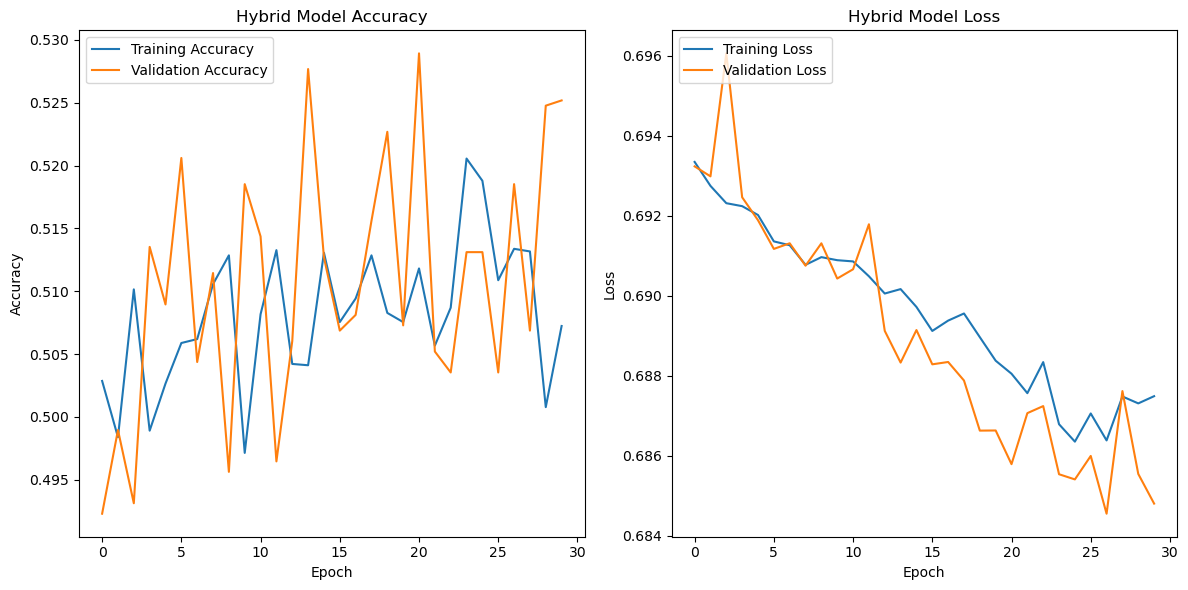

In [36]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping

# Assuming you have X_train, y_train, X_test, y_test defined

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define generator instances
train_generator = SparseMatrixBatchGenerator(X_train, y_train, batch_size=32)
test_generator = SparseMatrixBatchGenerator(X_test, y_test, batch_size=32)

# Define and compile the hybrid model
hybrid_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the generator
hybrid_history = hybrid_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Make predictions
hybrid_predictions = hybrid_model.predict(test_generator)
hybrid_predictions = (hybrid_predictions > 0.5).astype(int)

# Evaluation metrics (replace with your actual evaluation function)
hybrid_metrics = evaluate_model(hybrid_predictions, y_test)
print("Hybrid Model Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*hybrid_metrics))

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hybrid_history.history['accuracy'], label='Training Accuracy')
plt.plot(hybrid_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hybrid_history.history['loss'], label='Training Loss')
plt.plot(hybrid_history.history['val_loss'], label='Validation Loss')
plt.title('Hybrid Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [37]:
# Make predictions with both CNN and RNN
cnn_predictions = cnn_model.predict(X_test_reshaped)
cnn_predictions = (cnn_predictions > 0.5).astype(int)

rnn_predictions = rnn_model.predict(X_test_reshaped)
rnn_predictions = (rnn_predictions > 0.5).astype(int)
hybrid_predictions = hybrid_model.predict(test_generator)
hybrid_predictions = (hybrid_predictions > 0.5).astype(int)


# Average the predictions (simple ensemble)
ensemble_predictions = (cnn_predictions + rnn_predictions + hybrid_predictions) / 3
ensemble_predictions = (ensemble_predictions > 0.5).astype(int)

# Evaluation metrics
ensemble_metrics = evaluate_model(ensemble_predictions, y_test)
print("Ensemble Model Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*ensemble_metrics))


76/76 [==============================] - 18s 229ms/step
Ensemble Model Metrics: Accuracy: 0.8327, Precision: 0.7752, Recall: 0.9298, F1-score: 0.8455


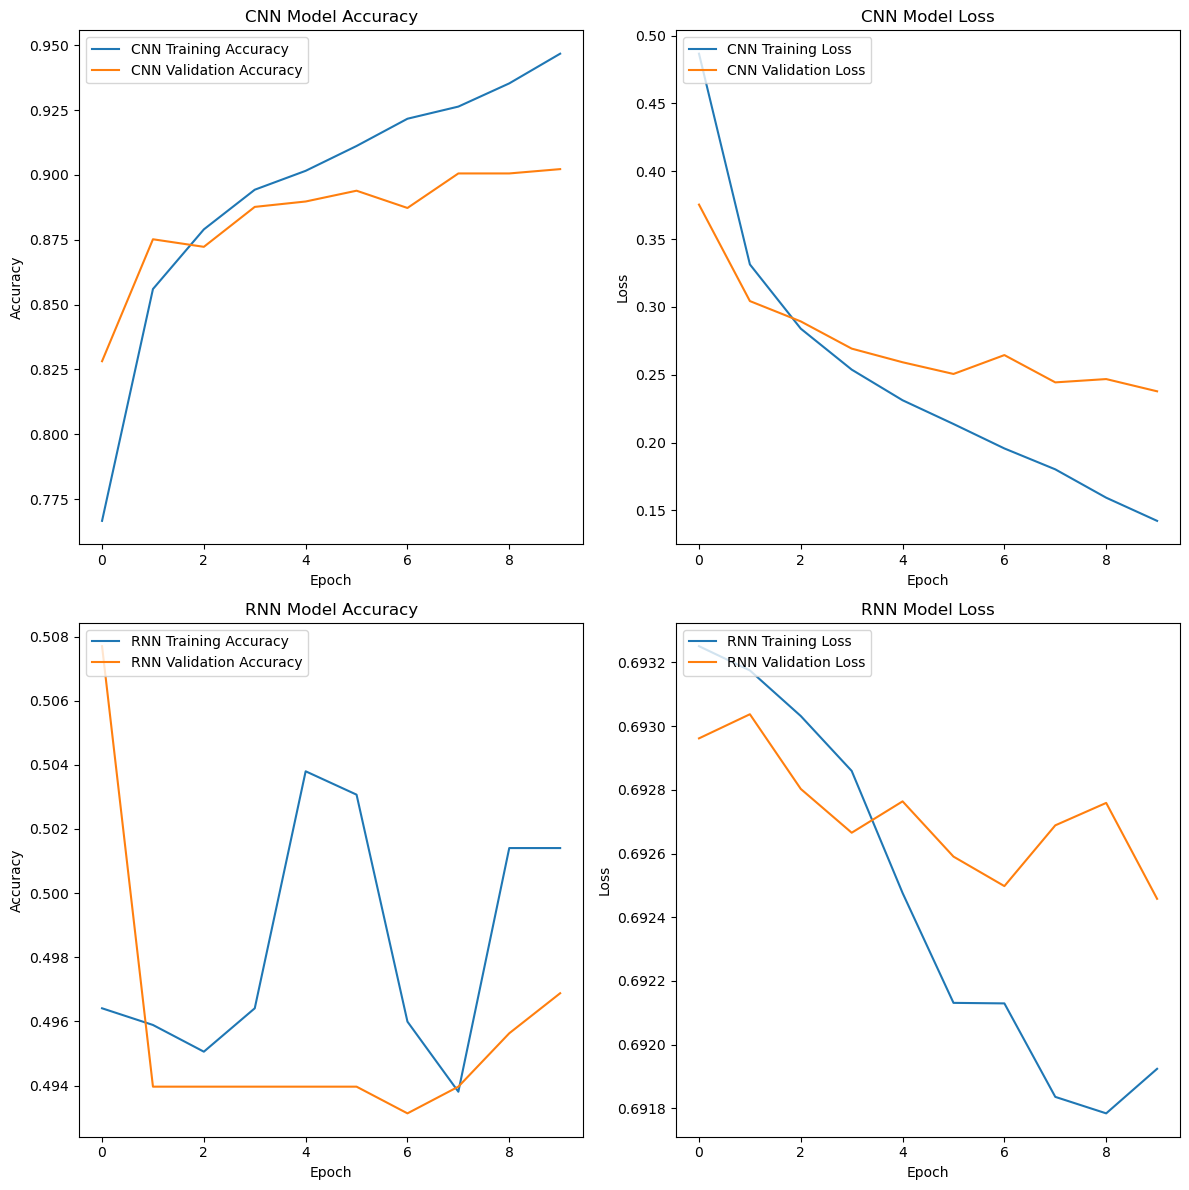

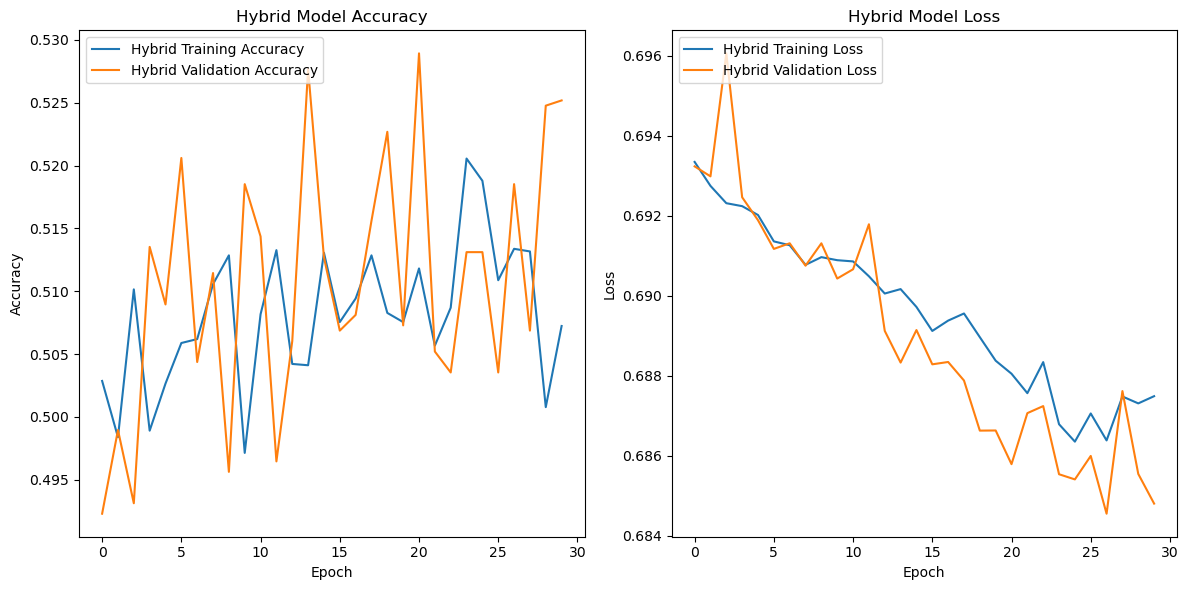

In [38]:
# Plotting combined training & validation accuracy and loss values
plt.figure(figsize=(12, 12))

# CNN Accuracy and Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='CNN Training Loss')
plt.plot(history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# RNN Accuracy and Loss
plt.subplot(2, 2, 3)
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(rnn_history.history['loss'], label='RNN Training Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Hybrid Accuracy and Loss (in a separate figure due to different training process)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hybrid_history.history['accuracy'], label='Hybrid Training Accuracy')
plt.plot(hybrid_history.history['val_accuracy'], label='Hybrid Validation Accuracy')
plt.title('Hybrid Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(hybrid_history.history['loss'], label='Hybrid Training Loss')
plt.plot(hybrid_history.history['val_loss'], label='Hybrid Validation Loss')
plt.title('Hybrid Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Confusion Matrix:
[[1096  124]
 [ 111 1072]]
TN: 1096, FP: 124, FN: 111, TP: 1072


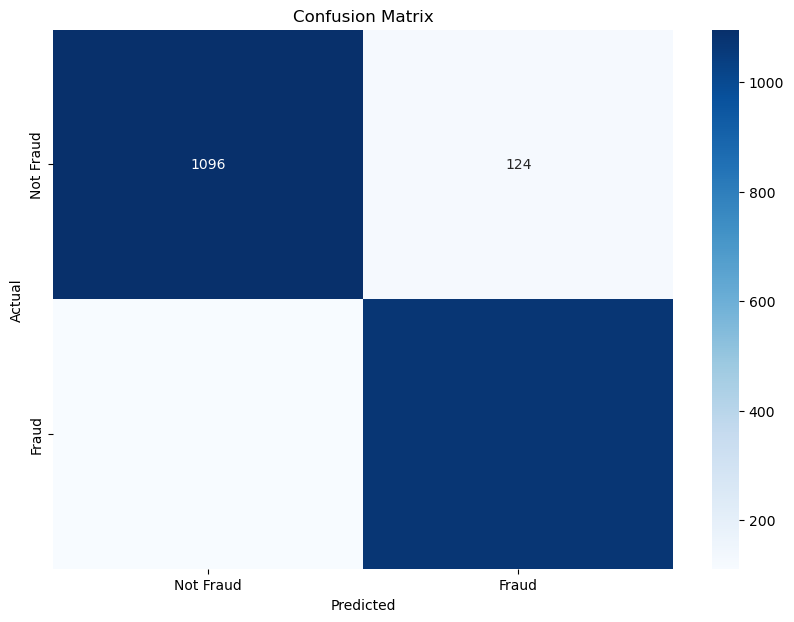

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cnn_predictions are the predicted labels for y_test
cm = confusion_matrix(y_test, cnn_predictions)

# Print confusion matrix values
print(f"Confusion Matrix:\n{cm}")

# Assign the values for easier reference
TN, FP, FN, TP = cm.ravel()

print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


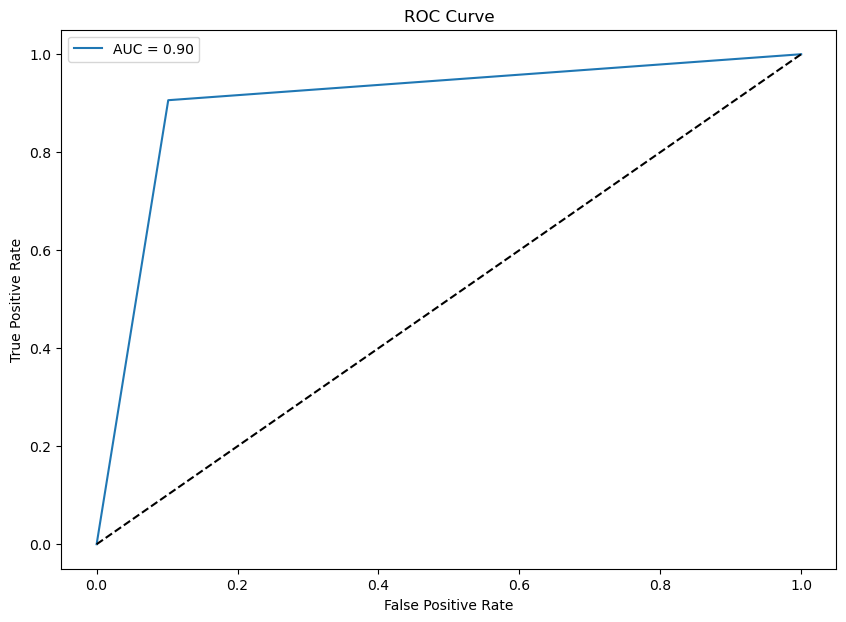

In [47]:
#ROC Curve and AUC Score
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, cnn_predictions)

# Calculate AUC score
auc_score = roc_auc_score(y_test, cnn_predictions)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


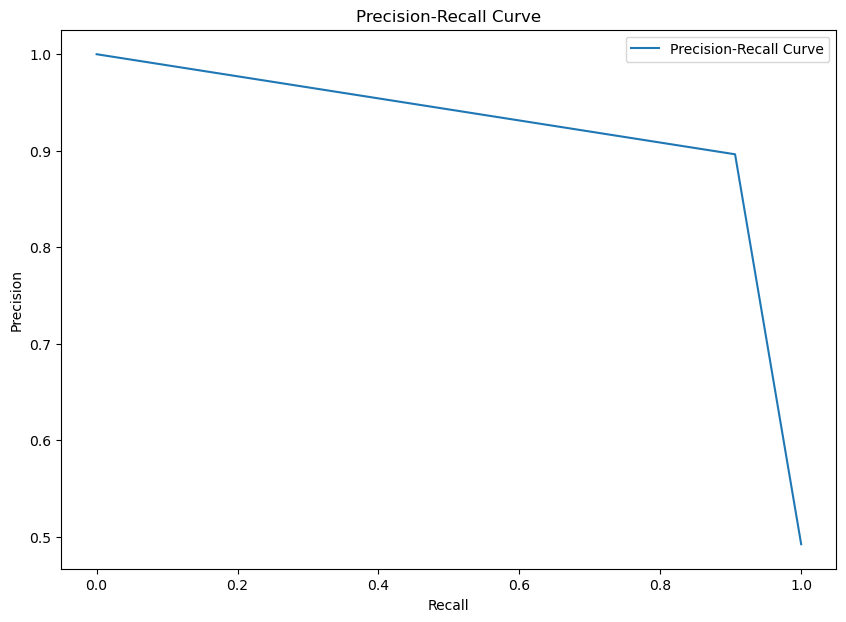

In [48]:
#Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, cnn_predictions)

# Plot precision-recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


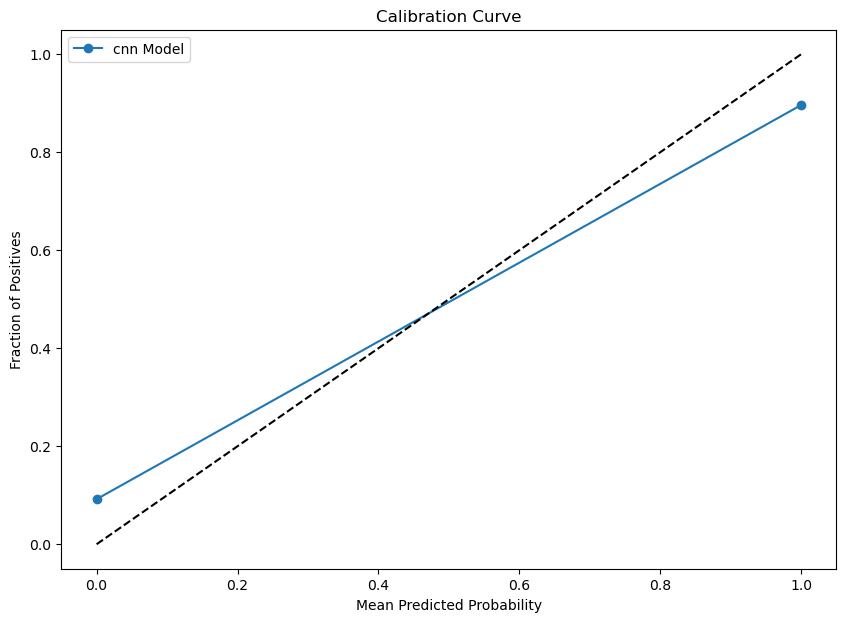

In [49]:
# Model Calibration
from sklearn.calibration import calibration_curve

# Generate calibration curve
prob_true, prob_pred = calibration_curve(y_test, cnn_predictions, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true, marker='o', label='cnn Model')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='best')
plt.show()


In [50]:
#CLASSIFICATION REPORTS
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, cnn_predictions, target_names=['Not Fraud', 'Fraud'])
print(report)


              precision    recall  f1-score   support

   Not Fraud       0.91      0.90      0.90      1220
       Fraud       0.90      0.91      0.90      1183

    accuracy                           0.90      2403
   macro avg       0.90      0.90      0.90      2403
weighted avg       0.90      0.90      0.90      2403



In [51]:
# Get predicted probabilities instead of binary predictions
cnn_probabilities = cnn_model.predict(X_test_reshaped)


76/76 [==============================] - 11s 58ms/step


In [52]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, cnn_probabilities)
roc_auc = roc_auc_score(y_test, cnn_probabilities)

# Print the TPR and FPR
print(f"TPR (True Positive Rate): {tpr}")
print(f"FPR (False Positive Rate): {fpr}")


TPR (True Positive Rate): [0.00000000e+00 8.45308538e-04 3.38123415e-03 5.07185123e-03
 1.77514793e-02 1.94420964e-02 2.78951817e-02 2.95857988e-02
 8.28402367e-02 8.45308538e-02 8.79120879e-02 8.79120879e-02
 1.53846154e-01 1.55536771e-01 4.46322908e-01 4.46322908e-01
 4.56466610e-01 4.56466610e-01 4.69146238e-01 4.69146238e-01
 4.78444632e-01 4.78444632e-01 5.02958580e-01 5.02958580e-01
 5.03803888e-01 5.03803888e-01 5.79881657e-01 5.79881657e-01
 5.93406593e-01 5.93406593e-01 5.95097210e-01 5.95097210e-01
 6.08622147e-01 6.08622147e-01 6.16229924e-01 6.16229924e-01
 6.32290786e-01 6.32290786e-01 6.40743872e-01 6.40743872e-01
 6.63567202e-01 6.63567202e-01 6.65257819e-01 6.65257819e-01
 6.77937447e-01 6.77937447e-01 6.85545224e-01 6.85545224e-01
 6.87235841e-01 6.87235841e-01 6.89771767e-01 6.89771767e-01
 7.03296703e-01 7.03296703e-01 7.08368555e-01 7.08368555e-01
 7.10904480e-01 7.10904480e-01 7.13440406e-01 7.13440406e-01
 7.18512257e-01 7.18512257e-01 7.21048183e-01 7.21048183e-0

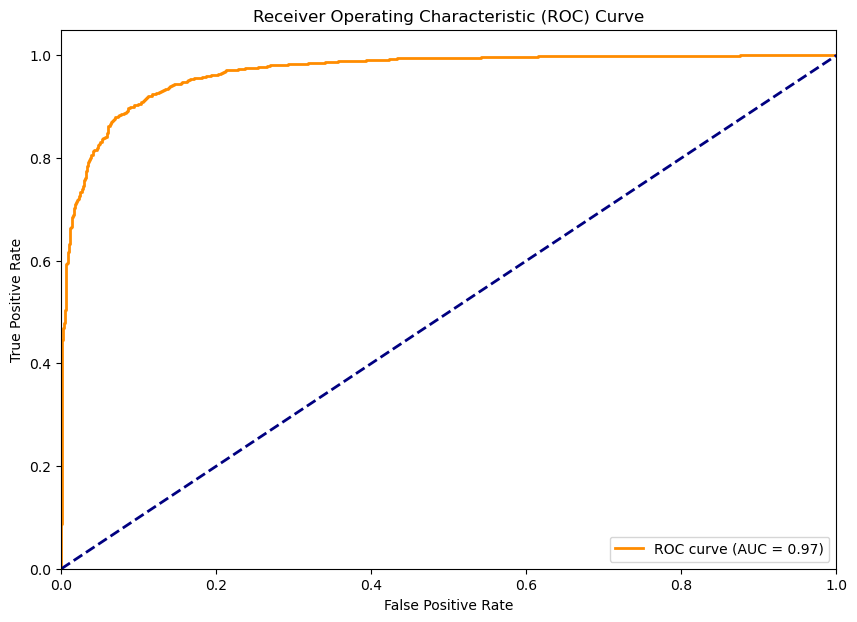

In [53]:
import matplotlib.pyplot as plt

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import category_encoders as ce

In [2]:
df = pd.read_csv('C:/Users/User/fraudTrain.csv')



In [3]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df[df.is_fraud == 0]
df_minority = df[df.is_fraud == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=6006,   # to match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_balanced['is_fraud'].value_counts())


is_fraud
0    6006
1    6006
Name: count, dtype: int64


In [4]:
# Handling non-numeric columns (e.g., dates)
# Convert 'Date' column to numerical format if it exists
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')
    df['Date'] = df['Date'].map(pd.Timestamp.to_julian_date)

In [5]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns


In [6]:
# Using category_encoders for more efficient encoding
encoder = ce.TargetEncoder(cols=categorical_columns)
df[categorical_columns] = encoder.fit_transform(df[categorical_columns], df['is_fraud'])


In [12]:
# Defining features and labels
X = df.drop(columns=['is_fraud'])  # Drop the target column
y = df['is_fraud']  # Target column

In [16]:
from sklearn.preprocessing import StandardScaler

# Preprocessing the data (Standardizing the features)
scaler = StandardScaler()
X_preprocessed = scaler.fit_transform(X)

# Identifying fraudulent and non-fraudulent
non_fraudulent = X_preprocessed[y == 0]
fraudulent = X_preprocessed[y == 1]


In [17]:

# Split the non-fraudulent data into training and test sets first
X_train, X_non_fraud_test, y_train, y_non_fraud_test = train_test_split(non_fraudulent, y[y == 0], test_size=0.2, random_state=42)
#combine the non-fraudulent test set with the fraudulent transactions for the final test set
X_test = np.concatenate([X_non_fraud_test, fraudulent])
y_test = np.concatenate([y_non_fraud_test, y[y == 1]])






In [18]:
# Defining the Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 14  # You can adjust this value

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
#Training the Autoencoder
history = autoencoder.fit(X_train, X_train,
                          epochs=25,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2
                         )



Epoch 1/25
2607/2607 [==============================] - 13s 4ms/step - loss: 0.4653 - val_loss: 0.3956
Epoch 2/25
2607/2607 [==============================] - 9s 3ms/step - loss: 0.3809 - val_loss: 0.3789
Epoch 3/25
2607/2607 [==============================] - 9s 4ms/step - loss: 0.3715 - val_loss: 0.3732
Epoch 4/25
2607/2607 [==============================] - 9s 3ms/step - loss: 0.3673 - val_loss: 0.3700
Epoch 5/25
2607/2607 [==============================] - 8s 3ms/step - loss: 0.3648 - val_loss: 0.3680
Epoch 6/25
2607/2607 [==============================] - 10s 4ms/step - loss: 0.3632 - val_loss: 0.3666
Epoch 7/25
2607/2607 [==============================] - 9s 3ms/step - loss: 0.3621 - val_loss: 0.3655
Epoch 8/25
2607/2607 [==============================] - 9s 3ms/step - loss: 0.3612 - val_loss: 0.3644
Epoch 9/25
2607/2607 [==============================] - 9s 3ms/step - loss: 0.3605 - val_loss: 0.3637
Epoch 10/25
2607/2607 [==============================] - 9s 4ms/step - loss: 0.3

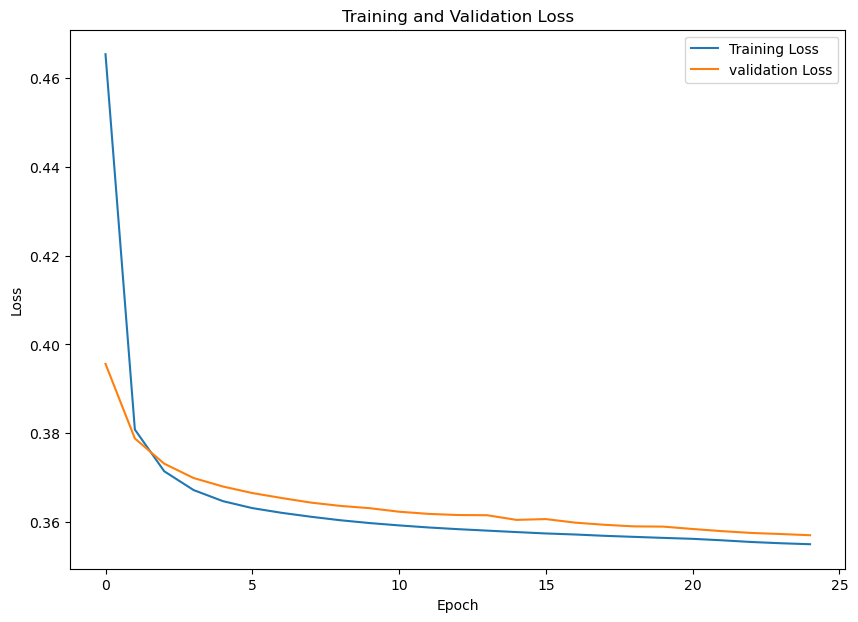

In [21]:
#Evaluating the Autoencoder
# Plot training & validation loss values
plt.figure(figsize = (10, 7) )
plt.plot(fpr, tpr, color='darkorage', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [22]:
#calculate the reconstruction error on test set
X_test_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)

6704/6704 [==============================] - 13s 2ms/step


In [25]:
#set threshold for detecting anomalies
threshold = np.percentile(mse, 97)
#classify test set transactions
y_pred = (mse > threshold).astype(int)

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Assuming y_test and y_pred are already defined

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score: ", roc_auc)


Confusion Matrix:
[[208084    430]
 [     0   6006]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    208514
           1       0.93      1.00      0.97      6006

    accuracy                           1.00    214520
   macro avg       0.97      1.00      0.98    214520
weighted avg       1.00      1.00      1.00    214520

ROC AUC Score:  0.9989688941749715


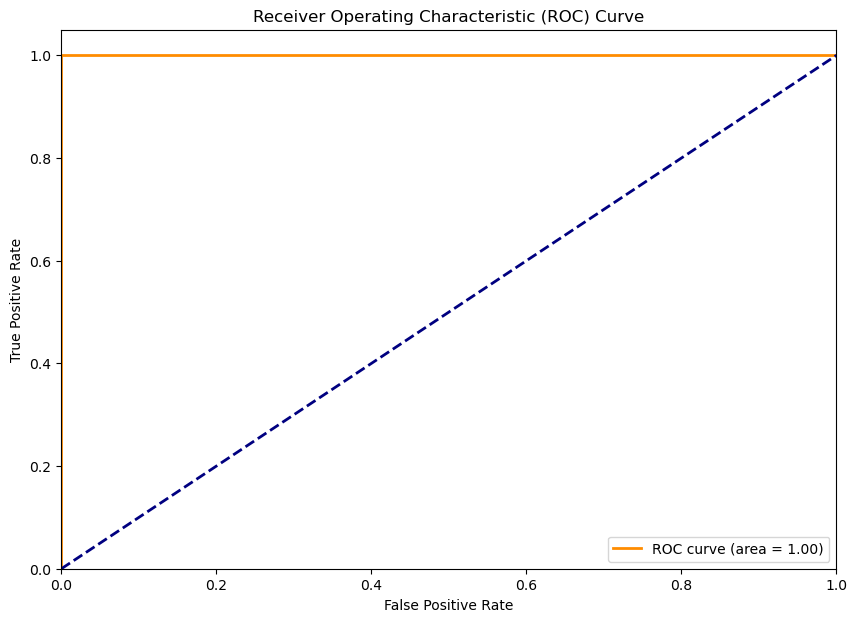

In [28]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, mse)
# Plotting the ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Summary plot for class 0 (Legitimate Transactions)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vm

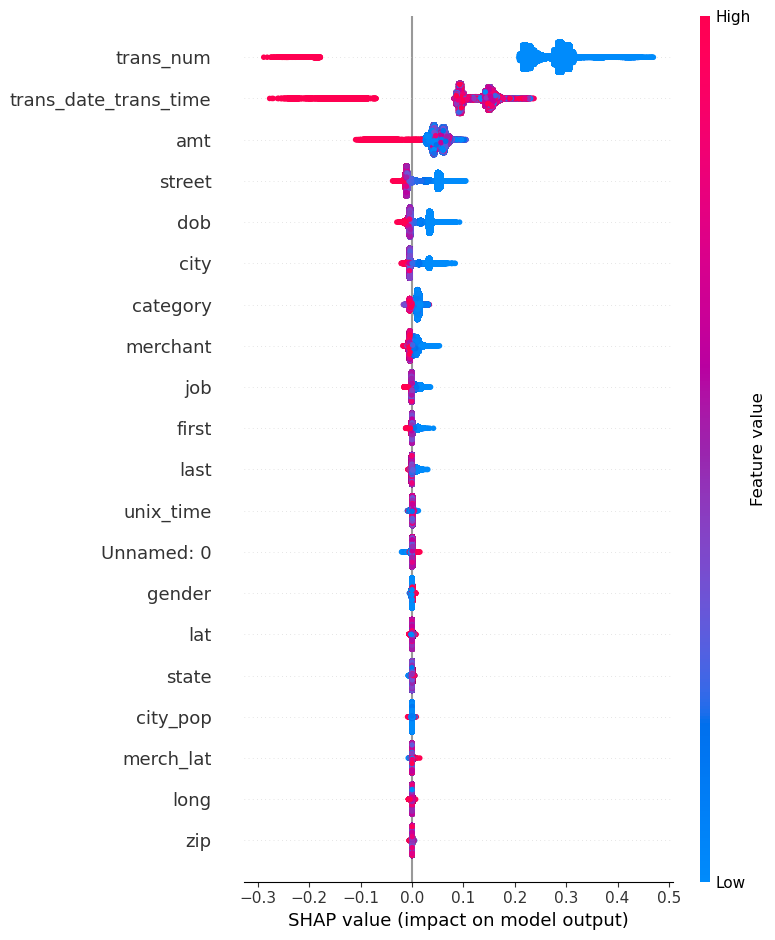

Summary plot for class 1 (Fraudulent Transactions)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


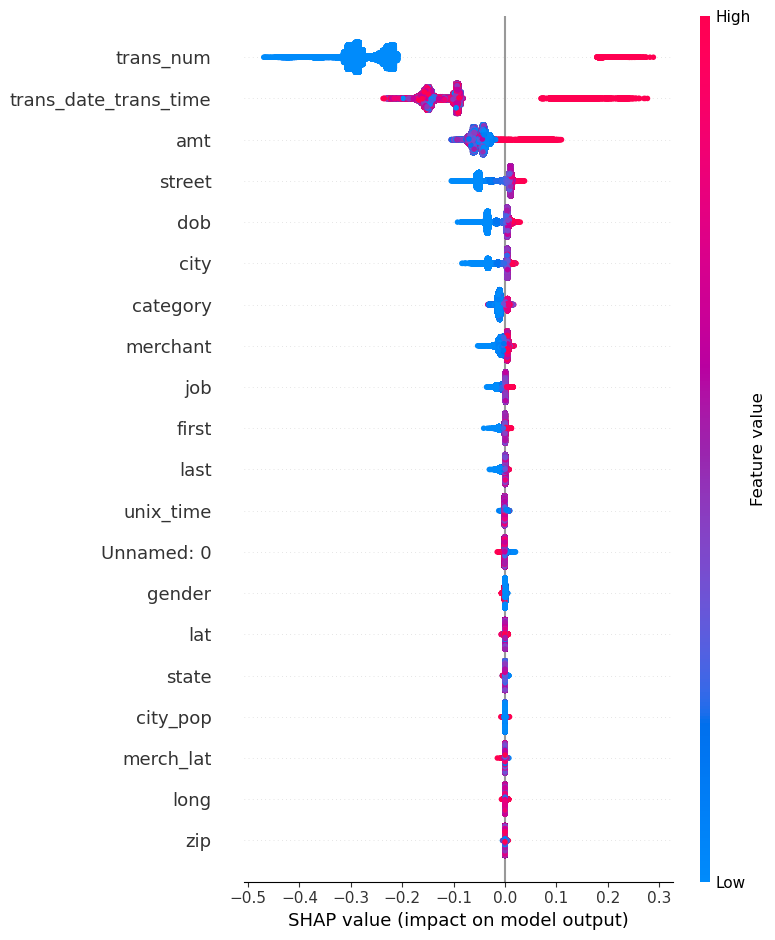

Dependence plot for 'trans_num' for class 0 (Legitimate Transactions)


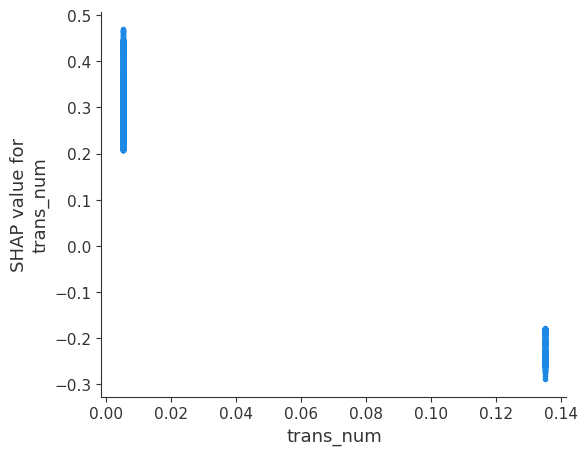

Dependence plot for 'trans_num' for class 1 (Fraudulent Transactions)


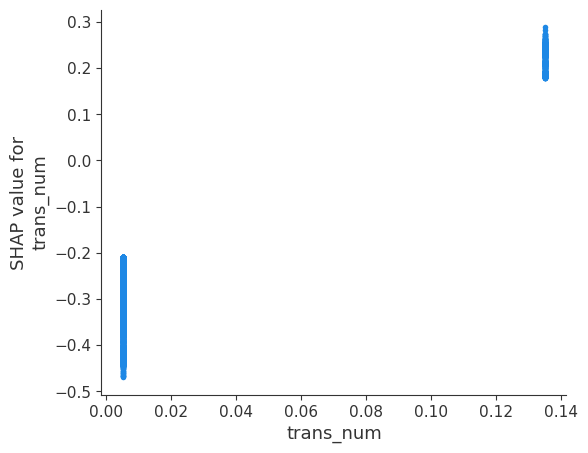

In [55]:
import shap
import matplotlib.pyplot as plt

# Assuming model is already trained and X_test is your test dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP values for class 0 (legitimate transactions)
shap_values_class_0 = shap_values[0]
# SHAP values for class 1 (fraudulent transactions)
shap_values_class_1 = shap_values[1]

# Summary plot for class 0
print("Summary plot for class 0 (Legitimate Transactions)")
shap.summary_plot(shap_values_class_0, X_test)

# Summary plot for class 1
print("Summary plot for class 1 (Fraudulent Transactions)")
shap.summary_plot(shap_values_class_1, X_test)

# Dependence plot for the 'trans_num' feature for class 0
print("Dependence plot for 'trans_num' for class 0 (Legitimate Transactions)")
shap.dependence_plot("trans_num", shap_values_class_0, X_test, interaction_index=None)

# Dependence plot for the 'trans_num' feature for class 1
print("Dependence plot for 'trans_num' for class 1 (Fraudulent Transactions)")
shap.dependence_plot("trans_num", shap_values_class_1, X_test, interaction_index=None)


Resampled Training Set Class Distribution:
is_fraud
0    4805
1    4805
Name: count, dtype: int64
Resampled Training Set Class Distribution:
is_fraud
0    4805
1    4805
Name: count, dtype: int64
Resampled Training Set Class Distribution:
is_fraud
0    4805
1    4805
Name: count, dtype: int64
Resampled Training Set Class Distribution:
is_fraud
0    4805
1    4805
Name: count, dtype: int64
Resampled Training Set Class Distribution:
is_fraud
0    4804
1    4804
Name: count, dtype: int64
Average Accuracy: 1.00
Average Precision: 1.00
Average Recall: 1.00
Average ROC AUC: 1.00


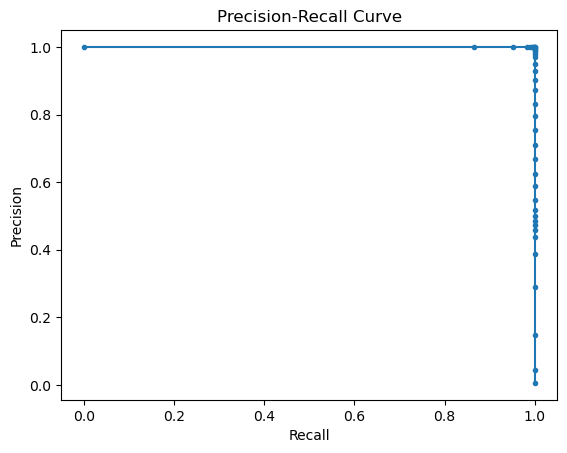

Confusion Matrix:
[[208513      0]
 [     0   1202]]


In [34]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

# Additional evaluation metrics
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Apply undersampling to the training data
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
    
    # Print class distribution after undersampling
    print("Resampled Training Set Class Distribution:")
    print(pd.Series(y_train_resampled).value_counts())
    
    # Train the model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on validation data
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    
    # Append metrics to lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    roc_auc_list.append(roc_auc)

# Calculate average metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_roc_auc = np.mean(roc_auc_list)

print(f"Average Accuracy: {avg_accuracy:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average ROC AUC: {avg_roc_auc:.2f}")

# Plot Precision-Recall Curve
y_val_prob = model.predict_proba(X_val)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_val_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


In [35]:
#Test on a Separate Dataset:evaluate the model on a completely independent test set to confirm if the performance holds up.
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
# Split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Apply undersampling to the training data
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test ROC AUC: {test_roc_auc:.2f}")


Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 1.00
Test ROC AUC: 1.00


In [36]:
#Complexity and Regularization: Experiment with different models and complexity levels. Use regularization techniques to prevent overfitting
from sklearn.model_selection import GridSearchCV

# Define the model and parameters
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the model with the best parameters on the validation set
y_val_pred = best_model.predict(X_val)
y_val_pred_prob = best_model.predict_proba(X_val)[:, 1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")
print(f"Validation ROC AUC: {val_roc_auc:.2f}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Validation Accuracy: 1.00
Validation Precision: 1.00
Validation Recall: 1.00
Validation ROC AUC: 1.00


In [37]:
# Check for Data Leakage
import numpy as np

# Check if there's any overlap in indices
def check_overlap(indices1, indices2):
    return np.any(np.in1d(indices1, indices2))

# Get indices from each split
train_indices = np.arange(len(X_train))
val_indices = np.arange(len(X_val))
test_indices = np.arange(len(X_test))

# Check overlaps
print("Overlap between train and validation indices:", check_overlap(train_indices, val_indices))
print("Overlap between train and test indices:", check_overlap(train_indices, test_indices))
print("Overlap between validation and test indices:", check_overlap(val_indices, test_indices))


Overlap between train and validation indices: True
Overlap between train and test indices: True
Overlap between validation and test indices: True


In [38]:
from sklearn.model_selection import train_test_split

# First, split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then, split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# Print class distribution in each set to verify
print("Training Set Class Distribution:")
print(pd.Series(y_train).value_counts())

print("Validation Set Class Distribution:")
print(pd.Series(y_val).value_counts())

print("Test Set Class Distribution:")
print(pd.Series(y_test).value_counts())


Training Set Class Distribution:
is_fraud
0    667244
1      3844
Name: count, dtype: int64
Validation Set Class Distribution:
is_fraud
0    166811
1       961
Name: count, dtype: int64
Test Set Class Distribution:
is_fraud
0    208514
1      1201
Name: count, dtype: int64


In [39]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Apply undersampling to the training data
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate on the validation set
y_val_pred = model.predict(X_val)
y_val_pred_prob = model.predict_proba(X_val)[:, 1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")
print(f"Validation ROC AUC: {val_roc_auc:.2f}")

# Predict and evaluate on the test set
y_test_pred = model.predict(X_test)
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test ROC AUC: {test_roc_auc:.2f}")


Validation Accuracy: 1.00
Validation Precision: 1.00
Validation Recall: 1.00
Validation ROC AUC: 1.00
Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 1.00
Test ROC AUC: 1.00


In [40]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with multiple splits
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"Cross-Validation ROC AUC Scores: {cross_val_scores}")
print(f"Mean Cross-Validation ROC AUC: {np.mean(cross_val_scores):.2f}")


Cross-Validation ROC AUC Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation ROC AUC: 1.00


In [41]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_resampled, y_train_resampled)
gb_y_test_pred = gb_model.predict(X_test)
gb_y_test_pred_prob = gb_model.predict_proba(X_test)[:, 1]

print(f"Gradient Boosting Test Accuracy: {accuracy_score(y_test, gb_y_test_pred):.2f}")
print(f"Gradient Boosting Test Precision: {precision_score(y_test, gb_y_test_pred):.2f}")
print(f"Gradient Boosting Test Recall: {recall_score(y_test, gb_y_test_pred):.2f}")
print(f"Gradient Boosting Test ROC AUC: {roc_auc_score(y_test, gb_y_test_pred_prob):.2f}")

# Support Vector Classifier
svc_model = SVC(probability=True)
svc_model.fit(X_train_resampled, y_train_resampled)
svc_y_test_pred = svc_model.predict(X_test)
svc_y_test_pred_prob = svc_model.predict_proba(X_test)[:, 1]

print(f"SVC Test Accuracy: {accuracy_score(y_test, svc_y_test_pred):.2f}")
print(f"SVC Test Precision: {precision_score(y_test, svc_y_test_pred):.2f}")
print(f"SVC Test Recall: {recall_score(y_test, svc_y_test_pred):.2f}")
print(f"SVC Test ROC AUC: {roc_auc_score(y_test, svc_y_test_pred_prob):.2f}")


Gradient Boosting Test Accuracy: 1.00
Gradient Boosting Test Precision: 1.00
Gradient Boosting Test Recall: 1.00
Gradient Boosting Test ROC AUC: 1.00
SVC Test Accuracy: 0.07
SVC Test Precision: 0.01
SVC Test Recall: 0.96
SVC Test ROC AUC: 0.50


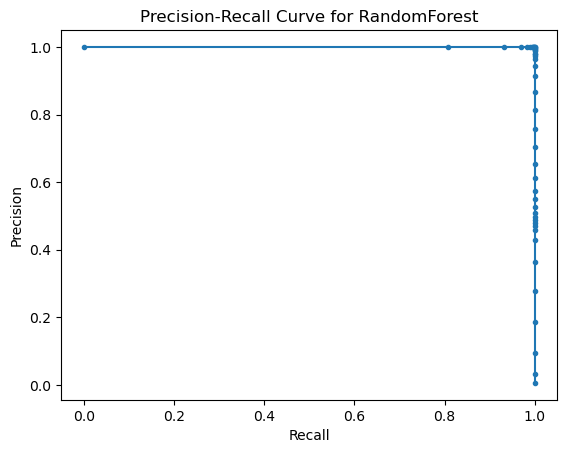

In [42]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Plot Precision-Recall Curve for RandomForest
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RandomForest')
plt.show()


In [43]:
import pandas as pd

# Example structure of feedback data
feedback_data = pd.DataFrame(columns=['predicted_class', 'actual_class', 'feedback_type', 'additional_info'])

# Function to collect feedback
def collect_feedback(predicted_class, actual_class, feedback_type, additional_info=''):
    global feedback_data
    feedback_data = feedback_data.append({
        'predicted_class': predicted_class,
        'actual_class': actual_class,
        'feedback_type': feedback_type,
        'additional_info': additional_info
    }, ignore_index=True)

# Save feedback data to a CSV file
feedback_data.to_csv('user_feedback.csv', index=False)


In [44]:
from dash import Dash, dcc, html
import plotly.express as px
import pandas as pd

# Load feedback data
feedback_data = pd.read_csv('user_feedback.csv')

# Example metric: Count of feedback types
feedback_counts = feedback_data['feedback_type'].value_counts().reset_index()
feedback_counts.columns = ['Feedback Type', 'Count']

# Create a Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("User Feedback Dashboard"),
    dcc.Graph(
        id='feedback-bar-chart',
        figure=px.bar(feedback_counts, x='Feedback Type', y='Count', title='Feedback Type Distribution')
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)


In [48]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pandas as pd

# Example data
performance_data = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'ROC AUC'],
    'Value': [1.00, 1.00, 1.00, 1.00]
})

feedback_data = pd.DataFrame({
    'Feedback Type': ['False Positive', 'False Negative'],
    'Count': [50, 30]
})

# Initialize the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Model Performance and Feedback Dashboard"),
    
    dcc.Graph(
        id='performance-metrics',
        figure=px.bar(performance_data, x='Metric', y='Value', title='Performance Metrics')
    ),
    
    dcc.Graph(
        id='feedback-metrics',
        figure=px.bar(feedback_data, x='Feedback Type', y='Count', title='Feedback Metrics')
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)


In [49]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import dash_daq as daq
import time

# Example data
performance_data = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'ROC AUC'],
    'Value': [1.00, 1.00, 1.00, 1.00]
})

feedback_data = pd.DataFrame({
    'Feedback Type': ['False Positive', 'False Negative'],
    'Count': [50, 30]
})

# Initialize the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Real-Time Model Performance and Feedback Dashboard"),
    
    daq.LEDDisplay(
        id='live-update-text',
        value='Updating...',
        size=30,
        color='green'
    ),
    
    dcc.Interval(
        id='interval-component',
        interval=10*1000,  # in milliseconds
        n_intervals=0
    ),
    
    dcc.Graph(id='performance-metrics'),
    
    dcc.Graph(id='feedback-metrics')
])

@app.callback(
    [Output('performance-metrics', 'figure'),
     Output('feedback-metrics', 'figure')],
    [Input('interval-component', 'n_intervals')]
)
def update_metrics(n):
    # Simulate data update
    performance_data['Value'] = performance_data['Value'] * (1 + 0.01 * (n % 5))
    feedback_data['Count'] = feedback_data['Count'] * (1 + 0.01 * (n % 5))
    
    performance_figure = px.bar(performance_data, x='Metric', y='Value', title='Performance Metrics')
    feedback_figure = px.bar(feedback_data, x='Feedback Type', y='Count', title='Feedback Metrics')
    
    return performance_figure, feedback_figure

if __name__ == '__main__':
    app.run_server(debug=True)
